In [1]:
library(tidyverse)
library(ggplot2)
library(ggpubr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“package ‘ggpubr’ was built under R version 4.3.1”


In [3]:
intra_prop_B6 <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/TAD/version_0912/raw_intra_prop_B6_112.csv") %>% rename(index = `...1`)
metadata <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/RNA_analysis/s1014_metadata_X_noM_noXistneg.csv")
tad <- read_csv("/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/TAD/new_version/my_tad_filtered_mod_tadE_new.csv") %>% select(-index) %>% rename(index = `...1`)

New names:
• `` -> `...1`
Rows: 112 Columns: 905
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (905): ...1, d0A1, d0A10, d0A11, d0A12, d0A13, d0A14, d0A15, d0A16, d0A1...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 904 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): ...1, orig.ident, sample2, sample3, cellcycle_threshold, day, cell...
dbl (11): nCount_RNA, nFeature_RNA, nCount_SCT, nFeature_SCT, SCT_snn_res.1....

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 112 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (6): ...1, ind

In [4]:
intra_prop_B6 %>% filter(index == 110) %>% column_to_rownames('index') %>% t() %>% as.data.frame() %>% rownames_to_column('cellname') %>% 
    left_join(metadata %>% select(cellname, plot_cluster)) %>% rename(TAD_110 = `110`) %>% filter(!is.na(TAD_110)) %>% group_by(plot_cluster) %>% summarise(mean = mean(TAD_110))

Joining with `by = join_by(cellname)`


plot_cluster,mean
<dbl>,<dbl>
0,0.2513620
1,0.2754252
2,0.2802468
3,0.2943165
4,0.2980843
5,0.2926392


In [5]:
tad %>% filter(end==5173)

index,start,end,distance,mask
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
66,5156,5173,17,18


In [6]:
tad %>% filter(start==5173)

index,start,end,distance,mask
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
110,5173,5185,12,12


In [7]:
tad %>% filter(start==5185)

index,start,end,distance,mask
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
111,5185,5204,19,19


In [8]:
res_B6 <- intra_prop_B6 %>% pivot_longer(!index, names_to = 'cellname', values_to = 'value') %>% left_join(metadata %>% select(cellname, plot_cluster)) %>%
    filter(plot_cluster %in% c(4,5,0)) %>% filter(!is.na(value)) %>%
    mutate(type = ifelse(plot_cluster %in% c(4,5), 'C4+C5', 'C0')) %>% 
    mutate(plot_cluster = paste0('C',plot_cluster)) %>% 
    group_by(index) %>%
    summarize(
        fold_change = mean(value[type == "C4+C5"]) / mean(value[type == "C0"]),
        p_value = wilcox.test(value[type == "C4+C5"], value[type == "C0"])$p.value
    ) %>%
    mutate(log2FoldChange = log2(fold_change),
           negLogPvalue = -log10(p_value))

Joining with `by = join_by(cellname)`


In [9]:
group1 <- intra_prop_B6 %>% pivot_longer(!index, names_to = 'cellname', values_to = 'value') %>% left_join(metadata %>% select(cellname, plot_cluster)) %>%
    filter(plot_cluster %in% c(4,5,0)) %>% 
    filter(!is.na(value)) %>%
    mutate(type = ifelse(plot_cluster %in% c(4,5), 'C4+C5', 'C0')) %>% filter(type == 'C4+C5') %>% filter(index == 110) %>% pull(value)

Joining with `by = join_by(cellname)`


In [10]:
group2 <- intra_prop_B6 %>% pivot_longer(!index, names_to = 'cellname', values_to = 'value') %>% left_join(metadata %>% select(cellname, plot_cluster)) %>%
    filter(plot_cluster %in% c(4,5,0)) %>% 
    filter(!is.na(value)) %>%
    mutate(type = ifelse(plot_cluster %in% c(4,5), 'C4+C5', 'C0')) %>% filter(type == 'C0') %>% filter(index == 110) %>% pull(value)

Joining with `by = join_by(cellname)`


In [11]:
wilcox.test(group1, group2)


	Wilcoxon rank sum test with continuity correction

data:  group1 and group2
W = 27054, p-value = 0.004217
alternative hypothesis: true location shift is not equal to 0


In [12]:
wilcox.test(group1, group2, alternative = 'g')


	Wilcoxon rank sum test with continuity correction

data:  group1 and group2
W = 27054, p-value = 0.002109
alternative hypothesis: true location shift is greater than 0


In [13]:
res_B6 <- res_B6 %>% mutate(sig = ifelse(p_value < 0.05, 'sig', 'notsig')) %>% 
    mutate(updown = ifelse((log2FoldChange > 0)&(p_value < 0.05), 'increase',ifelse((log2FoldChange < 0)&(p_value < 0.05), 'decrease','notsig')))

In [14]:
res_B6 <- res_B6 %>% 
    mutate(marker_name = ifelse(index == '110','TAD-E[Xist-Xert]', ifelse(index == '111','TAD-E[Xert-Rlim]', ifelse(index == '66','TAD-D', 'others'))))

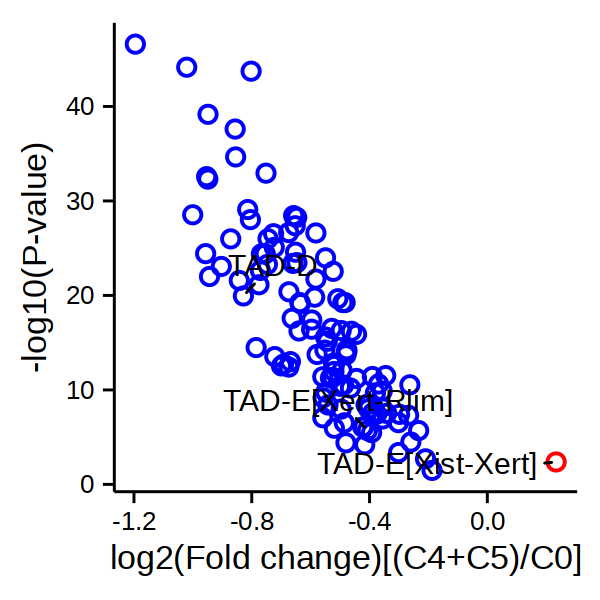

In [15]:
library(ggrepel)
options(repr.plot.width=2,repr.plot.height=2,repr.plot.res=300)
ggplot() +
  geom_point(data = res_B6 %>% filter(sig == 'notsig'), aes(x=log2FoldChange, y=negLogPvalue), shape=21, color='grey', fill='white', alpha=0.8) +
  geom_point(data = res_B6 %>% filter(updown == 'increase'), aes(x=log2FoldChange, y=negLogPvalue), shape=21, color='red') +
  geom_point(data = res_B6 %>% filter(updown == 'decrease'), aes(x=log2FoldChange, y=negLogPvalue), shape=21, color='blue') +
  geom_text_repel(data = res_B6 %>% filter(index %in% c(66, 110, 111)),
                  aes(x=log2FoldChange, y=negLogPvalue, label=marker_name),
                  max.overlaps = getOption("ggrepel.max.overlaps", default = 20),
                  size = 2.5,
                  min.segment.length = unit(0, 'lines'),
                  segment.size = 0.25) +
  xlab("log2(Fold change)[(C4+C5)/C0]") +
  ylab("-log10(P-value)") +
  theme_classic() + 
  theme(legend.position = "top",
      text = element_text(family="Arial", size=6),
      panel.border = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.line = element_line(color="black", linewidth = 0.25),
      axis.ticks = element_line(color="black", linewidth = 0.25),
      axis.text = element_text(color="black",size=6),
      legend.key = element_rect(colour = NA),
      legend.key.width = unit(0.3, "cm"),
      legend.key.height = unit(0.4, "cm"),
      axis.title=element_text(color="black",size=8,face="plain"),
  )

In [16]:
res_B6 <- intra_prop_B6 %>% pivot_longer(!index, names_to = 'cellname', values_to = 'value') %>% left_join(metadata %>% select(cellname, plot_cluster)) %>%
    filter(plot_cluster %in% c(4,5,0)) %>% 
    filter(!is.na(value)) %>%
    mutate(type = ifelse(plot_cluster %in% c(4,5), 'C4+C5', 'C0')) %>% 
    mutate(plot_cluster = paste0('C',plot_cluster)) %>% 
    group_by(index) %>%
    summarize(
        fold_change = mean(value[type == "C4+C5"]) / mean(value[type == "C0"]),
        p_value = wilcox.test(value[type == "C4+C5"], value[type == "C0"], alternative = "greater")$p.value
    ) %>%
    mutate(log2FoldChange = log2(fold_change),
           negLogPvalue = -log10(p_value))

Joining with `by = join_by(cellname)`


In [17]:
res_B6 <- res_B6 %>% mutate(sig = ifelse(p_value < 0.05, 'sig', 'notsig')) %>% 
    mutate(updown = ifelse((log2FoldChange > 0)&(p_value < 0.05), 'increase',ifelse((log2FoldChange < 0)&(p_value < 0.05), 'decrease','notsig')))

In [18]:
res_B6 <- res_B6 %>% 
    mutate(marker_name = ifelse(index == '110','TAD-E[Xist-Xert]', ifelse(index == '111','TAD-E[Xert-Rlim]', ifelse(index == '66','TAD-D', 'others'))))

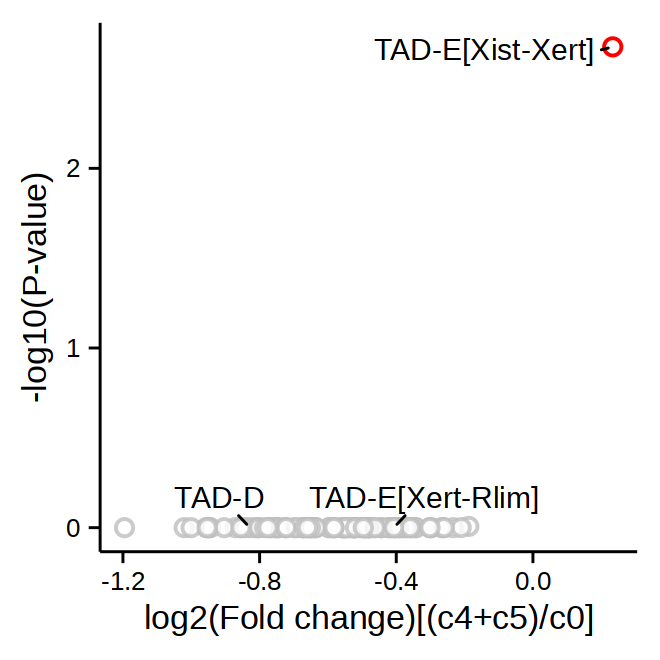

In [19]:
library(ggrepel)
options(repr.plot.width=2.2,repr.plot.height=2.2,repr.plot.res=300)
ggplot() +
  geom_point(data = res_B6 %>% filter(sig == 'notsig'), aes(x=log2FoldChange, y=negLogPvalue), shape=21, color='grey', fill='white', alpha=0.8) +
  geom_point(data = res_B6 %>% filter(updown == 'increase'), aes(x=log2FoldChange, y=negLogPvalue), shape=21, color='red') +
  geom_point(data = res_B6 %>% filter(updown == 'decrease'), aes(x=log2FoldChange, y=negLogPvalue), shape=21, color='blue') +
  geom_text_repel(data = res_B6 %>% filter(index %in% c(66, 110, 111)),
                  aes(x=log2FoldChange, y=negLogPvalue, label=marker_name),
                  max.overlaps = getOption("ggrepel.max.overlaps", default = 20),
                  size = 2.5,
                  min.segment.length = unit(0, 'lines'),
                  segment.size = 0.25) +
  xlab("log2(Fold change)[(c4+c5)/c0]") +
  ylab("-log10(P-value)") +
  theme_classic() + 
  theme(legend.position = "top",
      text = element_text(family="Arial", size=6),
      panel.border = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.line = element_line(color="black", linewidth = 0.25),
      axis.ticks = element_line(color="black", linewidth = 0.25),
      axis.text = element_text(color="black",size=6),
      legend.key = element_rect(colour = NA),
      legend.key.width = unit(0.3, "cm"),
      legend.key.height = unit(0.4, "cm"),
      axis.title=element_text(color="black",size=8,face="plain"),
  )

# ggsave("figures_raw_score/fig2I_TADE_siginificance.svg", width = 2.2, height = 2.2, units = "in", dpi = 300)

In [20]:
esc.AS <- readRDS('/share/Data/hxie/project/202209/esc_xwliu/esc1014_halfday/RNA_analysis/RDS/esc_AS_remove_neg_904.rds')
esc.mc <- readRDS('/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/GADI/esc_mc.rds')
mc_metadata <- read_csv('/share/Data/hxie/project/202209/esc_xwliu/esc0615_version2/HiC_analysis/GADI/metacell_metadata.csv')

Rows: 889 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): index, orig.ident, sample2, sample3, cellcycle_threshold, day, cel...
dbl (13): nCount_RNA, nFeature_RNA, nCount_SCT, nFeature_SCT, SCT_snn_res.1....

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [21]:
b6_xist <- esc.AS$SCT@data['B6-Xist',] %>% as.data.frame()
names(b6_xist) <- 'b6_xist'
b6_xist <- b6_xist %>% rownames_to_column('cellname')

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.4; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




Joining with `by = join_by(cellname)`
Joining with `by = join_by(cellname)`
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


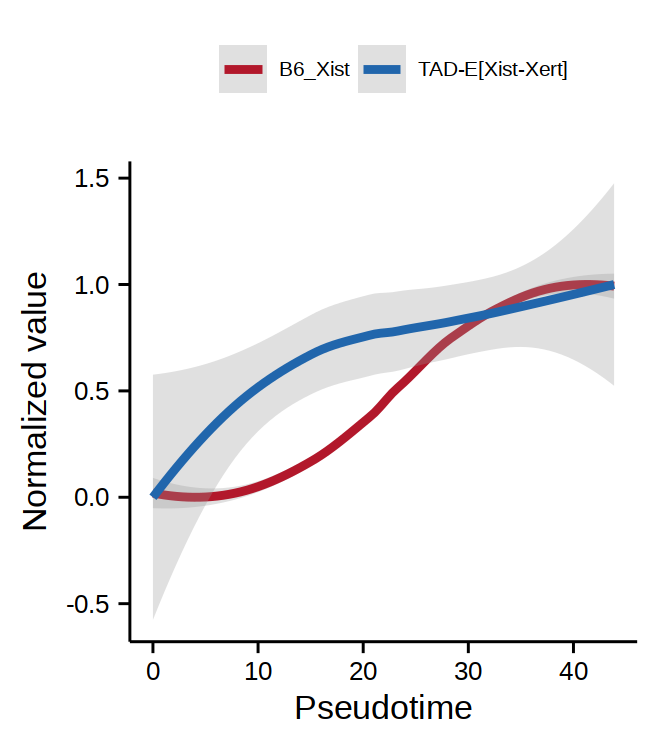

In [22]:
options(repr.plot.width=2.2,repr.plot.height=2.5,repr.plot.res=300)
p1 <- intra_prop_B6 %>% filter(index %in% c(110)) %>% pivot_longer(!index, names_to = 'cellname', values_to = 'score') %>% filter(!is.na(score)) %>%
left_join(metadata %>% select(cellname, plot_cluster, curve1, curve2)) %>% select(-index) %>% mutate(type = 'TAD-E[Xist-Xert]') %>% rename(value = score) %>% 
    rbind(b6_xist %>% left_join(metadata %>% select(cellname, plot_cluster, curve1, curve2)) %>% mutate(type = 'B6_Xist') %>% rename(value = b6_xist)) %>% filter(!is.na(curve1)) %>%
    rename(time1 = curve1) %>% group_by(type) %>% mutate(fitted_raw = predict(loess(value ~ time1, span = 1), se=T)$fit,fitted = (fitted_raw - min(fitted_raw))/(max(fitted_raw)-min(fitted_raw)),
                                          high = fitted + qt(0.975,predict(loess(value ~ time1, span = 1), se=T)$df)*predict(loess(value ~ time1, span = 1), se=T)$se, high = (high - min(high))/(max(high)-min(high)),
                                          low = fitted - qt(0.975,predict(loess(value ~ time1, span = 1), se=T)$df)*predict(loess(value ~ time1, span = 1), se=T)$se, low = (low - min(low))/(max(low)-min(low))) %>%
    mutate(norm_value = (value - min(fitted_raw))/(max(fitted_raw) - min(fitted_raw))) %>%
    select(-c(value,fitted_raw,fitted,high,low)) %>% 
    group_by(type)  %>% ggplot(aes(x=time1,y=norm_value,color=type))+ geom_smooth(aes(group=type), span = 1, alpha = 0.3, linewidth = 0.75) +
    scale_color_manual(values = c("#b2182b","#2166ac")) +
    ylab("Normalized value") +xlab("Pseudotime") + labs(color = "") +
    theme_classic() + 
    theme(legend.position = "top",
      text = element_text(family="Arial", size=6),
      panel.border = element_blank(),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(),
      panel.background = element_blank(),
      axis.line = element_line(color="black", linewidth = 0.25),
      axis.ticks = element_line(color="black", linewidth = 0.25),
      axis.text = element_text(color="black",size=6),
      legend.key = element_rect(colour = NA),
      legend.key.width = unit(0.4, "cm"),
      legend.key.height = unit(0.4, "cm"),
      axis.title=element_text(color="black",size=8,face="plain"),
  )
p1
# ggsave("fig2K_Xist_TADE_curve.svg", width = 2.2, height = 2.5, units = "in", dpi = 300)